<a href="https://colab.research.google.com/github/18521509/TTDPT_PY/blob/master/BT02_GTDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymoo

#Solve problem

In [73]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.algorithms.moead import MOEAD
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_performance_indicator
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.termination.default import MultiObjectiveDefaultTermination as MDT
from pymoo.factory import get_problem, get_visualization, get_reference_directions
from matplotlib import pyplot as plt
seed = 18521509

#Algorithms

In [74]:
def plot_result(resF, pf,name, tuning, pop_size, gd):  
    plt.figure(figsize = (16,9))
    plt.title(f'Problem {name}, {tuning} = {pop_size}, gd = {gd:.5f}', fontsize = 20)
    plt.plot(pf[:,0],pf[:,1], color="black", alpha=0.7)
    plt.scatter(resF[:,0],resF[:,1], color="red")
    plt.show()

##NSGA2 Algorithm

In [75]:
def NSGA2_algo(problem_name, pop_size = 400 , n_max_evals = 1e5, n_max_gen = 200,  seed = 18521509):

    problem = get_problem(problem_name)
    pf = problem.pareto_front()
    algorithm = NSGA2(pop_size = pop_size)

    termination = MDT(n_max_evals = n_max_evals, n_max_gen = n_max_gen)

    res = minimize(problem = problem,
                algorithm = algorithm, termination = 
                termination,
                seed=seed,
                verbose=False)

    gd = get_performance_indicator("gd", pf)
    gd.calc(res.F)
    return gd.calc(res.F), res.F, pf
    


### NSGA2: pop_size tuning

In [76]:
def bisec_NSGA2(problem_name, n_max_evals = 1e5, seed = 18521509):
    
    n = 1
    n_min = 0
    while True: 
        n*=2
        gd, F, pf = NSGA2_algo(problem_name = problem_name,pop_size =  n, n_max_evals = n_max_evals, seed = seed)
        if gd <= 0.008:
            n_max = n
            break

    n_min = n_max // 2
    while n_min < n_max - 1:
        mid = int((n_max + n_min)/2)
        gd, F, pf = NSGA2_algo(problem_name = problem_name,pop_size =  mid, n_max_evals = n_max_evals, seed = seed)
        if gd > 0.008:
            n_min = mid
        else:
            n_max = mid

    gd, F, pf = NSGA2_algo(problem_name = problem_name,pop_size =  n_max, n_max_evals = n_max_evals, seed = seed)
    return n_max, gd, F, pf



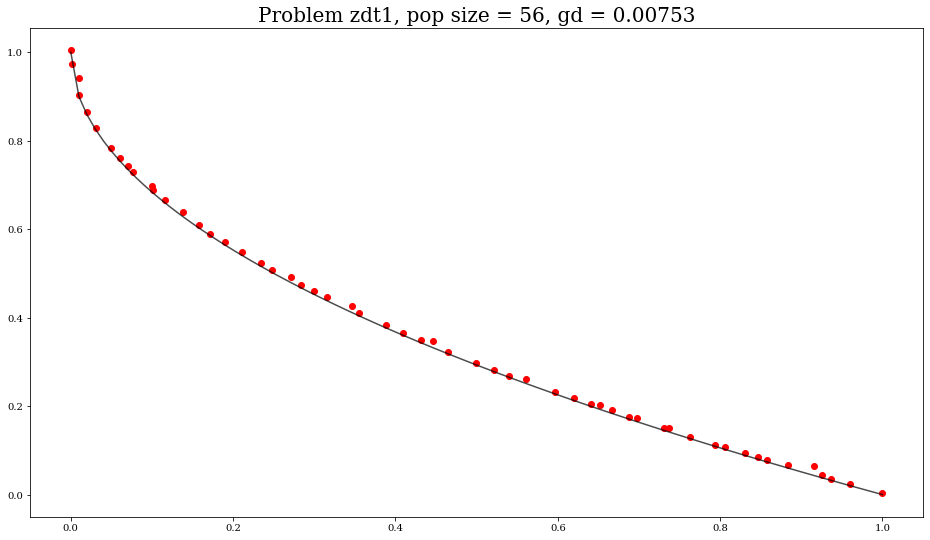

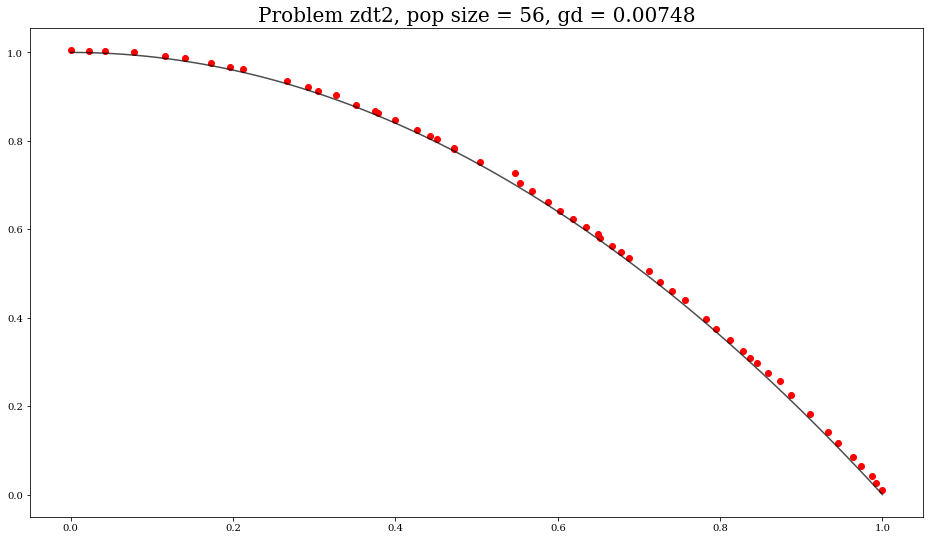

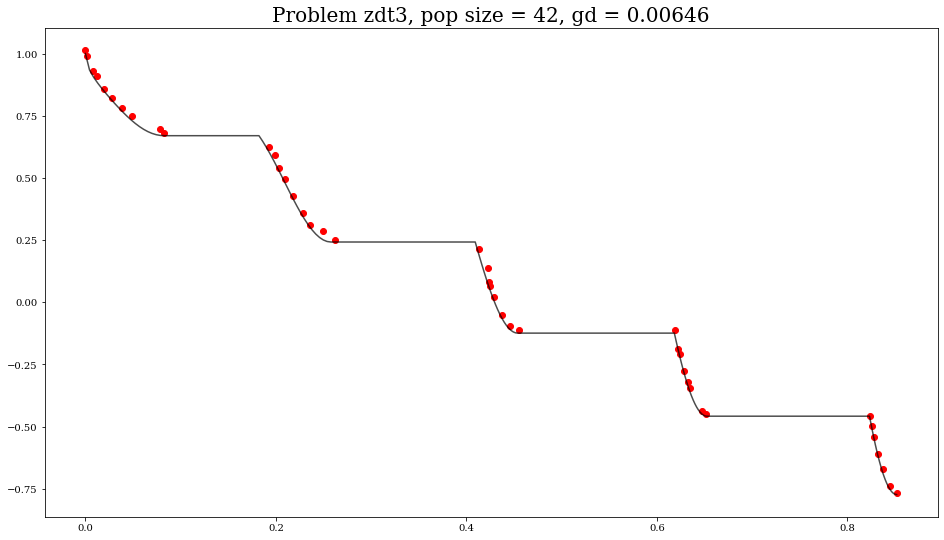

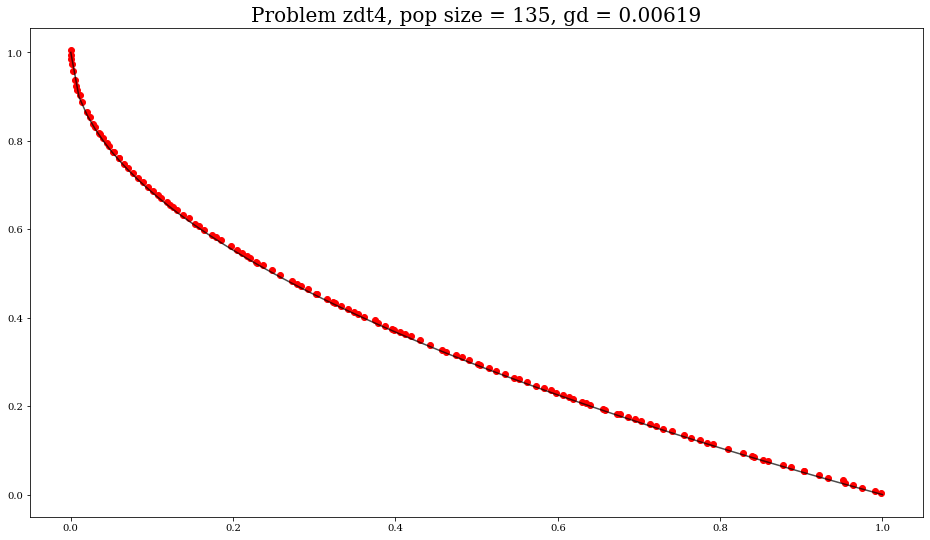

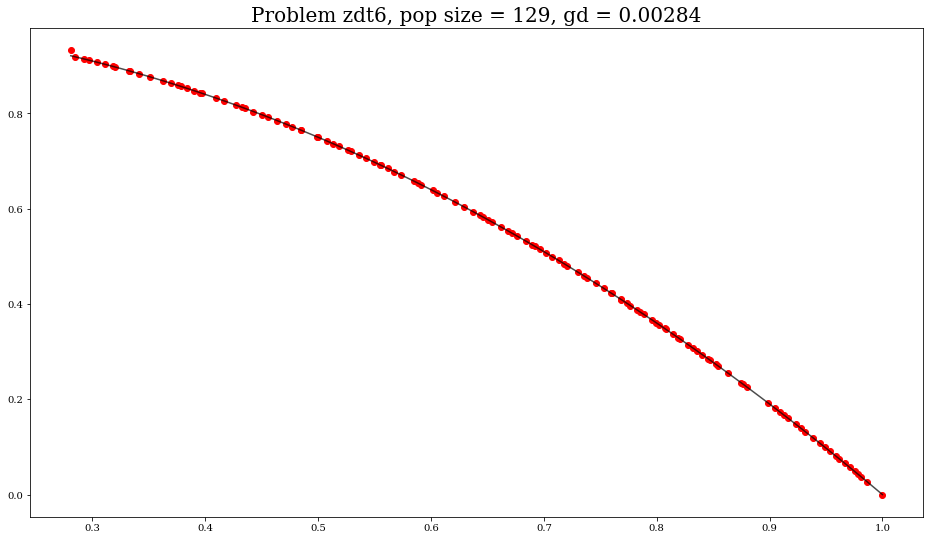

In [77]:
zdts = ['zdt1', 'zdt2', 'zdt3', 'zdt4', 'zdt6']
zdt_pop_size = []
for zdt in zdts: 
    res = bisec_NSGA2(zdt,n_max_evals = 1e5)
    zdt_pop_size.append(res[0])
    plot_result(res[2],res[3],zdt,'pop size', res[0],res[1])

###NSGA2: n_gen tuning

In [78]:
def bisec_n_gen_NSGA2(problem_name, n_max_evals = 1e5, seed = 18521509):
    
    n = 1
    n_min = 0
    while True: 
        n*=2
        gd, F, pf = NSGA2_algo(problem_name = problem_name, n_max_evals = n_max_evals, n_max_gen = n, seed = seed)
        if gd <= 0.008:
            n_max = n
            break

    n_min = n_max // 2
    while n_min < n_max - 1:
        mid = int((n_max + n_min)/2)
        gd, F, pf = NSGA2_algo(problem_name = problem_name, n_max_evals = n_max_evals, n_max_gen = mid, seed = seed)
        if gd > 0.008:
            n_min = mid
        else:
            n_max = mid

    gd, F, pf = NSGA2_algo(problem_name = problem_name, n_max_evals = n_max_evals, n_max_gen = n_max, seed = seed)
    return n_max, gd, F, pf



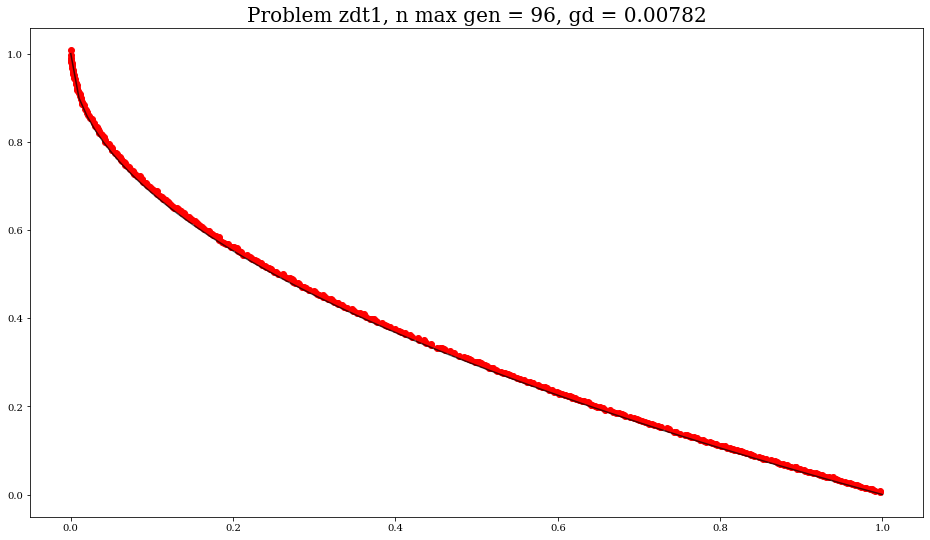

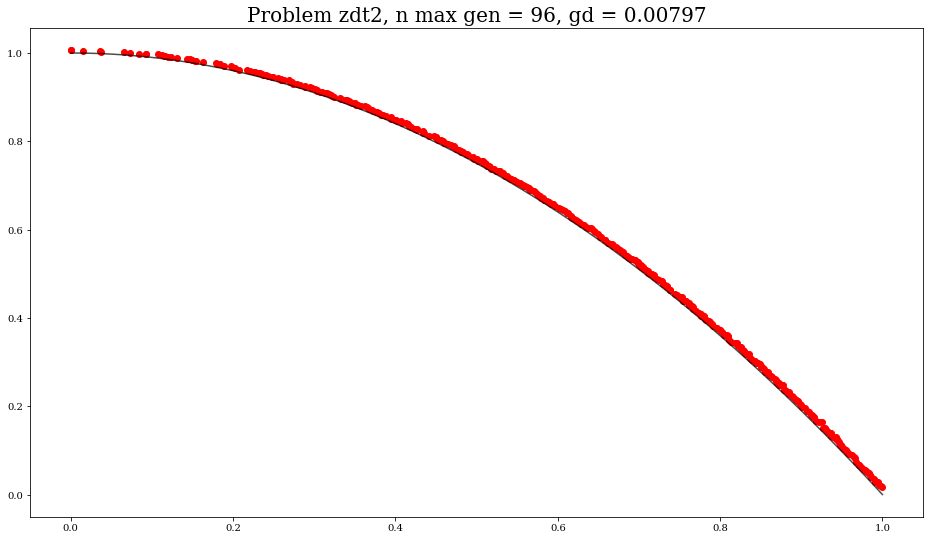

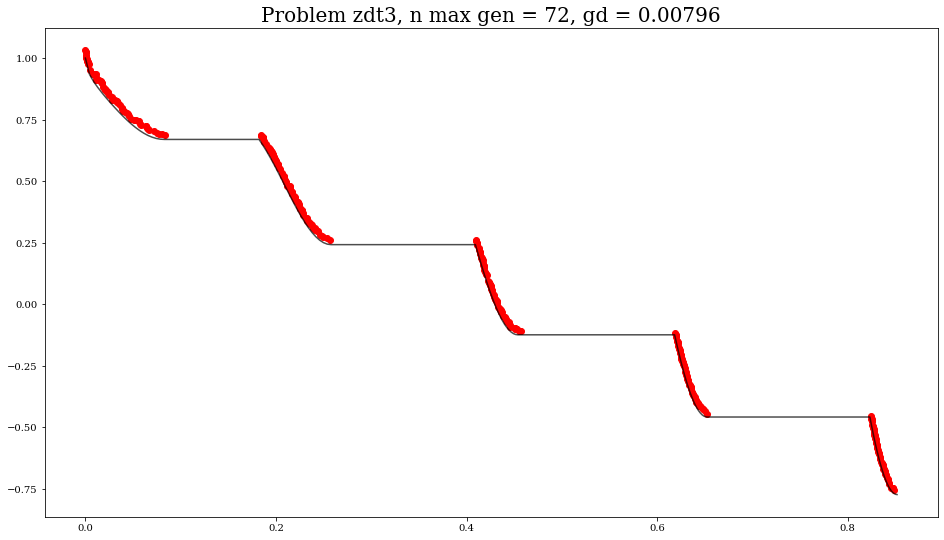

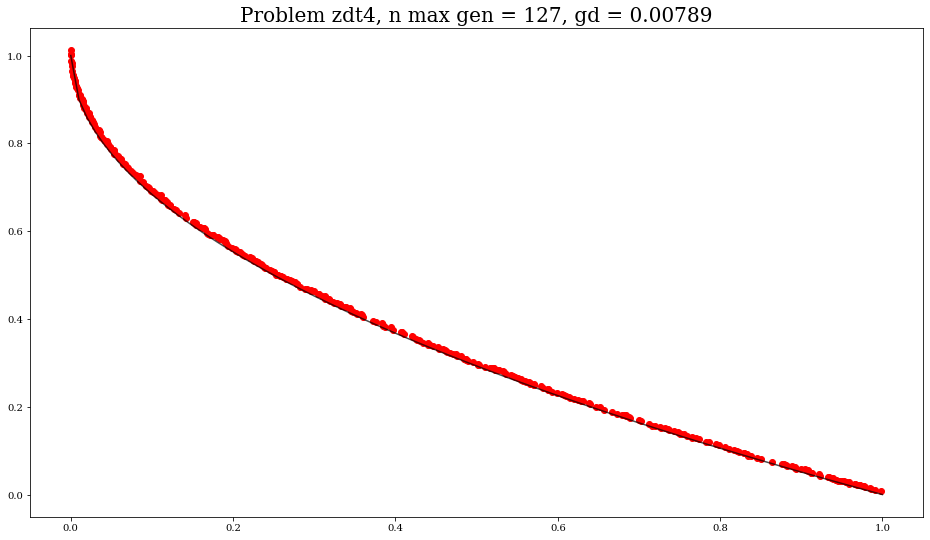

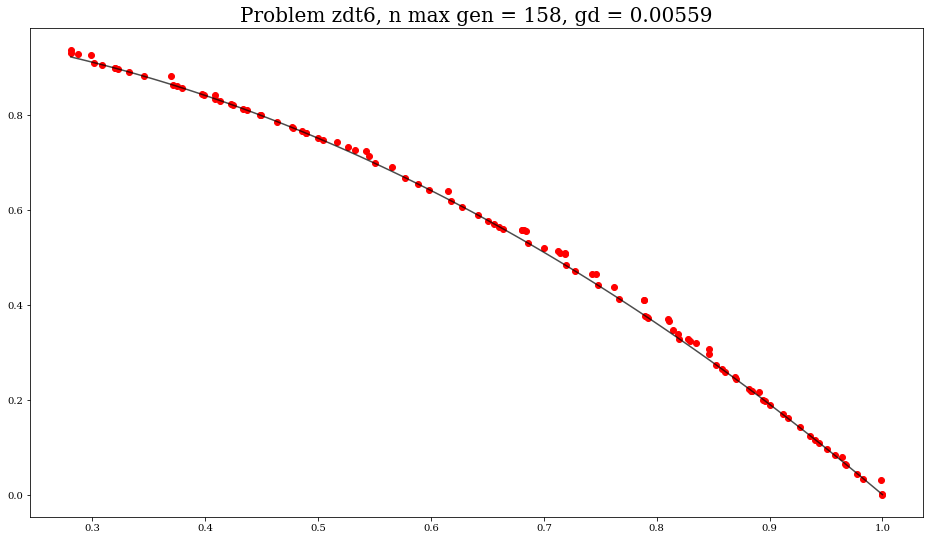

In [79]:
zdts = ['zdt1', 'zdt2', 'zdt3', 'zdt4', 'zdt6']
zdt_pop_size = []
for zdt in zdts: 
    res = bisec_n_gen_NSGA2(zdt,n_max_evals = 1e5)
    zdt_pop_size.append(res[0])
    plot_result(res[2],res[3],zdt,'n max gen', res[0],res[1])

## MOEAD:

In [80]:
def MOEAD_algo(problem_name, n_max_evals = 1e5, n_gen  = 100,  seed = 18521509):

    problem = get_problem(problem_name)

    algorithm = MOEAD(
        get_reference_directions("das-dennis", 3, n_partitions=12),
        n_neighbors=30,
        decomposition="pbi",
        prob_neighbor_mating=0.7,
        seed= seed
    )

    res = minimize(problem, algorithm, termination=('n_gen', n_gen),n_max_evals = n_max_evals)

    pf = problem.pareto_front()
    gd = get_performance_indicator("gd", pf)
    return gd.calc(res.F), res.F, pf

 ### MOEAD: n_gen tuning

In [81]:
def bisec_MOEAD(problem_name, n_max_evals = 1e5, seed = 18521509): 
    n = 1

    while True: 
        n*=2
        gd, F, pf = MOEAD_algo(problem_name = problem_name,  n_max_evals = n_max_evals, n_gen = n, seed = seed)
        if gd <= 0.008:
            print(f'n upper bound {n:<4d}| gd: {gd:.5f} ')
            n_max = n
            break

    n_min = n_max // 2
    while n_min < n_max - 1:
        mid = int((n_max + n_min)/2)
        gd, F, pf = MOEAD_algo(problem_name = problem_name, n_max_evals = n_max_evals, n_gen = mid, seed = seed)
        if gd > 0.008:
            n_min = mid
        else:
            n_max = mid
        print(f'mid: {mid:<4d}| gd: {gd:5f} | n_max = {n_max:<4d}| n min {n_min:<4d}')

    gd, F, pf = MOEAD_algo(problem_name = problem_name, n_max_evals = n_max_evals, n_gen = n_max,  seed = seed)
    return n_max, gd, F, pf

n upper bound 64  | gd: 0.00614 
mid: 48  | gd: 0.008340 | n_max = 64  | n min 48  
mid: 56  | gd: 0.006101 | n_max = 56  | n min 48  
mid: 52  | gd: 0.007088 | n_max = 52  | n min 48  
mid: 50  | gd: 0.007189 | n_max = 50  | n min 48  
mid: 49  | gd: 0.031630 | n_max = 50  | n min 49  


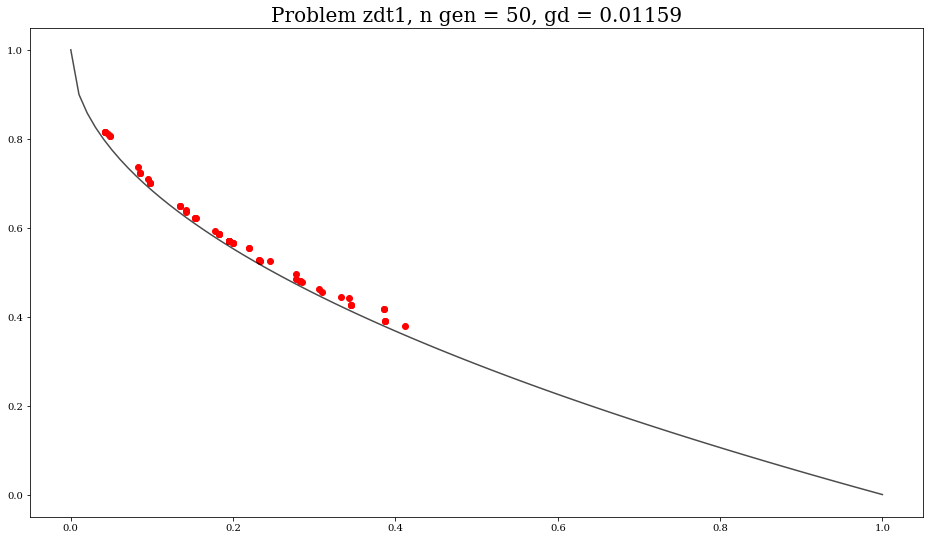

n upper bound 64  | gd: 0.00154 
mid: 48  | gd: 0.001894 | n_max = 48  | n min 32  
mid: 40  | gd: 0.001103 | n_max = 40  | n min 32  
mid: 36  | gd: 0.001799 | n_max = 36  | n min 32  
mid: 34  | gd: 0.002602 | n_max = 34  | n min 32  
mid: 33  | gd: 0.006414 | n_max = 33  | n min 32  


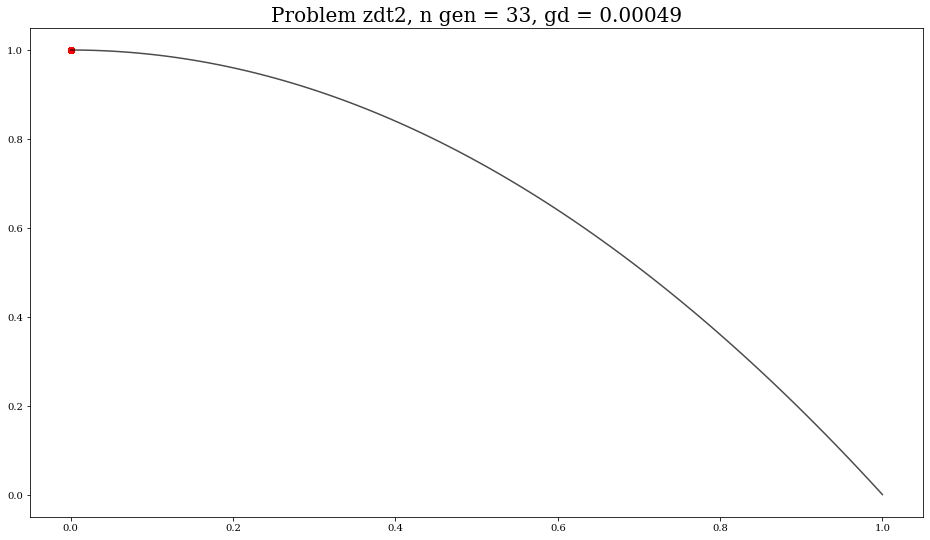

n upper bound 128 | gd: 0.00327 
mid: 96  | gd: 0.003241 | n_max = 96  | n min 64  
mid: 80  | gd: 0.005720 | n_max = 80  | n min 64  
mid: 72  | gd: 0.006583 | n_max = 72  | n min 64  
mid: 68  | gd: 0.007077 | n_max = 68  | n min 64  
mid: 66  | gd: 0.003214 | n_max = 66  | n min 64  
mid: 65  | gd: 0.007567 | n_max = 65  | n min 64  


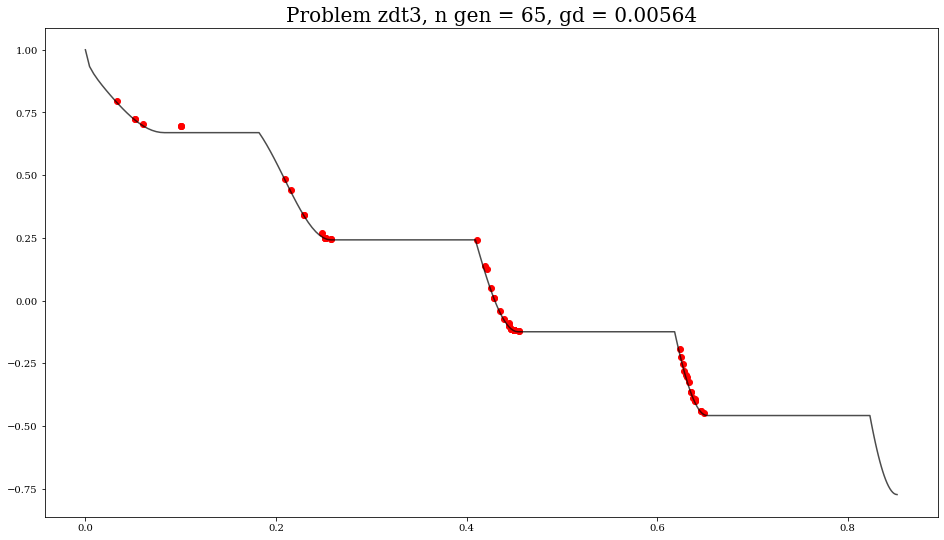

n upper bound 256 | gd: 0.00550 
mid: 192 | gd: 0.004530 | n_max = 192 | n min 128 
mid: 160 | gd: 0.007454 | n_max = 160 | n min 128 
mid: 144 | gd: 0.009103 | n_max = 160 | n min 144 
mid: 152 | gd: 0.009470 | n_max = 160 | n min 152 
mid: 156 | gd: 0.009816 | n_max = 160 | n min 156 
mid: 158 | gd: 0.007129 | n_max = 158 | n min 156 
mid: 157 | gd: 0.006551 | n_max = 157 | n min 156 


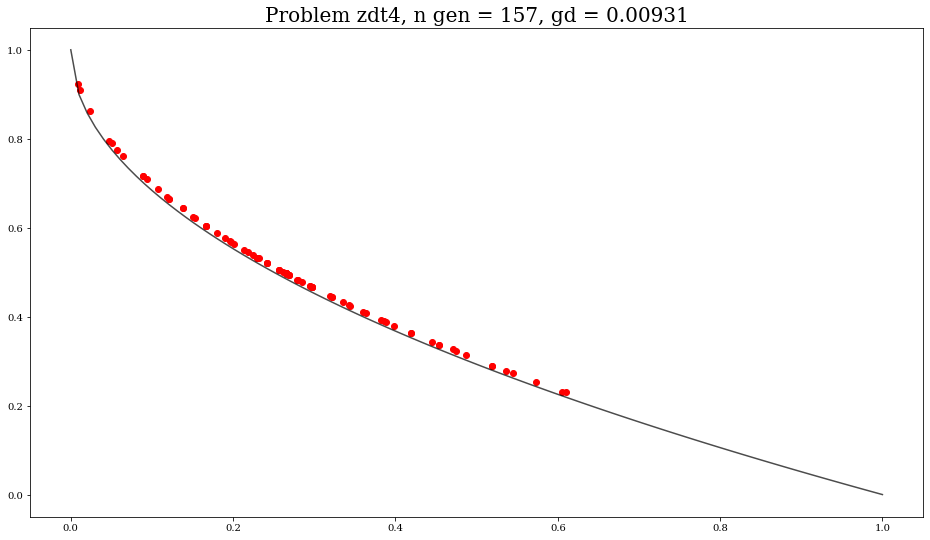

n upper bound 64  | gd: 0.00363 
mid: 48  | gd: 0.021591 | n_max = 64  | n min 48  
mid: 56  | gd: 0.006329 | n_max = 56  | n min 48  
mid: 52  | gd: 0.020191 | n_max = 56  | n min 52  
mid: 54  | gd: 0.011637 | n_max = 56  | n min 54  
mid: 55  | gd: 0.020042 | n_max = 56  | n min 55  


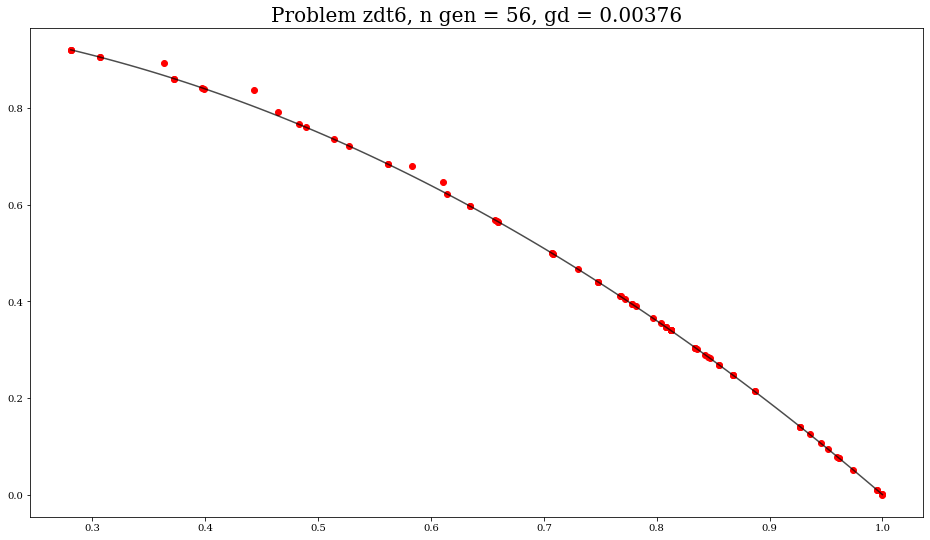

In [82]:
zdts = ['zdt1', 'zdt2', 'zdt3', 'zdt4', 'zdt6']
MOEAD_n_gen = []
MOEAD_gd = []
for zdt in zdts: 
    res = bisec_MOEAD(zdt,n_max_evals = 1e5)
    MOEAD_n_gen.append(res[0]) 
    MOEAD_gd.append(res[1])
    plot_result(res[2],res[3],zdt, 'n gen', res[0],res[1])

#Đánh giá
 

## Quy trình thực hiện:
- Các thuật toán sử dụng độ đo Generational Distance
- Chấp nhận kết quả khi $GD \le 0.008$
- Tìm uperbound, sau đó dùng chặt nhị phân tìm $n\_gen$ hoặc $pop\_size$ phù hợp

- Giới hạn n_evals = $10^5$

Thực hiện tuning n_gen và pop_size với thuật toán NSGA2, tuning n_gen với MOEAD



##Đánh giá thuật toán
- Thuật toán NSGA2 cho kết quả ổn định. Cùng 1 pop_size hoặc n_gen ở các lần chạy khác nhau cho kết quả tương đương nhau
- Thuật toán MOEAD cho kết quả không ổn định khi chạy cùng một giới hạn n_gen. (Có thể xem kết quả các bước chạy bisection ở phần trên)